# 💾 📊 CIFSC Data - Treatment & Analysis 📊 💾

In [91]:
import pandas as pd

import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

In [92]:
myCSVfile = ("merged.csv")
mergedDF = pd.read_csv(myCSVfile)
mergedDF.head()

,Unnamed: 0,Month of Date,Year of Date,Month Number,ETF,Sponsor,Sponsor Category,CIFSC,Fund Name,Net Assets,Gross Sales,Redemptions
0,0,January 2016,2016,1,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,183094000.0,937000.0,2397000.0
1,1,February 2016,2016,2,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,172025000.0,812000.0,1825000.0
2,2,March 2016,2016,3,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,172097000.0,604000.0,1880000.0
3,3,April 2016,2016,4,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,168156000.0,273310.0,1843800.0
4,4,May 2016,2016,5,N,AGF,Independents,U.S. Small/Mid Cap Equity,AGF U.S. Small-Mid Cap Fund,177464000.0,516000.0,1638000.0


## Regroup categories

In [93]:
myCSVfile = ("CIFSCCategories.csv")
CIFSCCategories = pd.read_csv(myCSVfile)
CIFSCCategories = CIFSCCategories.rename(columns = {"Original Category":"CIFSC", "Consolidated Category": "ConsolidatedCIFSC"})
CIFSCCategories.head()

,CIFSC,ConsolidatedCIFSC
0,Energy Equity,Sector Equity
1,International Equity,Global Equity
2,Miscellaneous - Undisclosed Holdings,Miscellaneous
3,Tactical Balanced,Balanced - Tactical
4,U.S. Small/Mid Cap Equity,U.S./North American Equity


In [94]:
# Add a column with the consolidated CIFSC
import duckdb

# Register both dataframes
duckdb.register("mergedDF", mergedDF)
duckdb.register("CIFSCCategories", CIFSCCategories)

# Perform a LEFT JOIN to add the ConsolidatedCIFSC column
query = """
SELECT 
    m.*,
    c.ConsolidatedCIFSC
FROM mergedDF m
LEFT JOIN CIFSCCategories c
    ON m.CIFSC = c.CIFSC
"""

# Run the query and assign the result back to mergedDF
mergedDF = duckdb.query(query).to_df()
print(mergedDF.head())



   Unnamed: 0   Month of Date  Year of Date  Month Number ETF Sponsor  \
0      409600       June 2023          2023            90   Y  Scotia   
1      409601       July 2023          2023            91   Y  Scotia   
2      409602     August 2023          2023            92   Y  Scotia   
3      409603  September 2023          2023            93   Y  Scotia   
4      409604    October 2023          2023            94   Y  Scotia   

  Sponsor Category                                 CIFSC  \
0            Banks  Miscellaneous - Undisclosed Holdings   
1            Banks  Miscellaneous - Undisclosed Holdings   
2            Banks  Miscellaneous - Undisclosed Holdings   
3            Banks  Miscellaneous - Undisclosed Holdings   
4            Banks  Miscellaneous - Undisclosed Holdings   

                                          Fund Name   Net Assets  Gross Sales  \
0  Scotia Emerging Markets Equity Index Tracker ETF  100331590.0          0.0   
1  Scotia Emerging Markets Equity Inde

## ⚪⚪ Minimal categories CIFSC

In [95]:
import duckdb

# Assuming your original dataframe is called df
duckdb.register("GroupedCIFSCandMonth", mergedDF)

query = """
SELECT 
  "Month Number", 
  CIFSC,
  SUM("Net Assets") AS total_net_assets,
  SUM("Gross Sales") AS total_gross_sales,
  SUM("Redemptions") AS total_redemptions,
FROM GroupedCIFSCandMonth
GROUP BY "Month Number", CIFSC;
"""

GroupedCIFSCandMonth = duckdb.query(query).to_df()
#print(GroupedCIFSCandMonth)
#GroupedCIFSCandMonth.head()

duckdb.register("my_CompleteOrdered_table", GroupedCIFSCandMonth)

query = """
SELECT *
FROM my_CompleteOrdered_table
ORDER BY CIFSC, "Month Number";
"""
resultOrdered_df = duckdb.query(query).to_df()
#print(resultOrdered_df)
resultOrdered_df.head()



,Month Number,CIFSC,total_net_assets,total_gross_sales,total_redemptions
0,1,2020 Target Date Portfolio,3.534000e+06,0.0,1075000.0
1,2,2020 Target Date Portfolio,0.000000e+00,0.0,2973000.0
2,1,2025 Target Date Portfolio,2.333079e+09,36431840.0,10765200.0
3,2,2025 Target Date Portfolio,2.335502e+09,40576870.0,12506660.0
4,3,2025 Target Date Portfolio,2.403915e+09,31539190.0,15161900.0


In [96]:
import duckdb

# Register your Pandas DataFrame as a DuckDB table
duckdb.register("my_Normalizedtable", resultOrdered_df)

query = """
SELECT 
  "Month Number", 
  CIFSC, 
  total_net_assets,
  total_gross_sales,
  total_redemptions,
  total_net_assets / FIRST_VALUE(total_net_assets) OVER (PARTITION BY CIFSC ORDER BY "Month Number") AS normalized_value
FROM my_Normalizedtable;
"""

# Execute the query and convert the result to a Pandas DataFrame.
Normalizedtable = duckdb.query(query).to_df()
Normalizedtable.head()



,Month Number,CIFSC,total_net_assets,total_gross_sales,total_redemptions,normalized_value
0,1,Energy Equity,2.869556e+09,165349430.0,91221320.0,1.000000
1,2,Energy Equity,2.892809e+09,307619650.0,226196750.0,1.008103
2,3,Energy Equity,3.153176e+09,125836980.0,131798630.0,1.098838
3,4,Energy Equity,3.244401e+09,115502910.0,171237840.0,1.130628
4,5,Energy Equity,3.231803e+09,281287140.0,367508630.0,1.126238


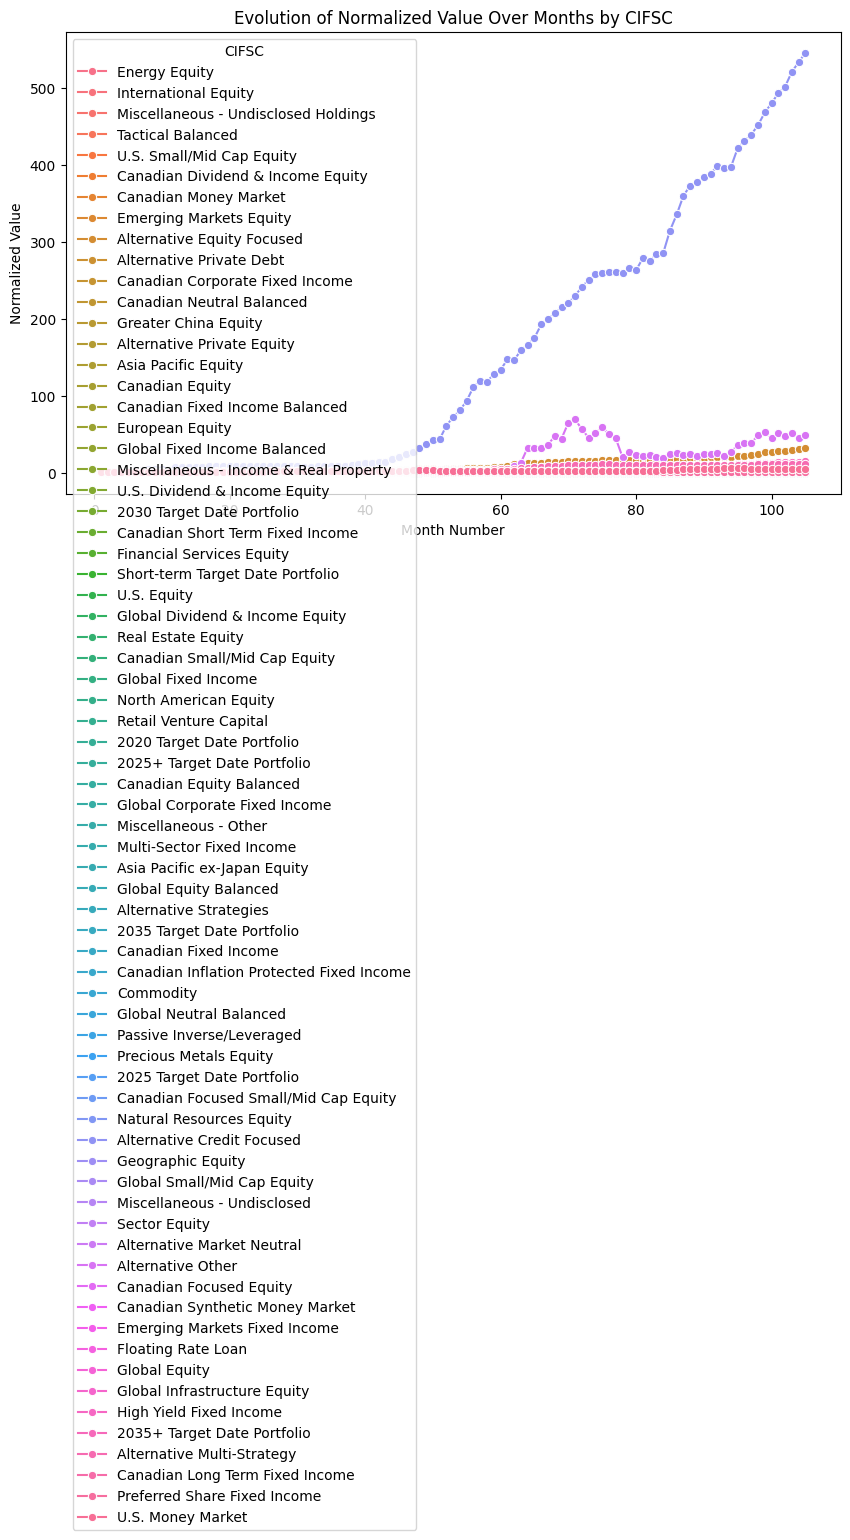

In [97]:
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

# Assuming your DataFrame is already loaded as df
# df = pd.read_csv('your_data.csv')  # or however you load it

plt.figure(figsize=(10, 6))
sns.lineplot(data=Normalizedtable, x='Month Number', y='normalized_value', hue='CIFSC', marker='o')
plt.title('Evolution of Normalized Value Over Months by CIFSC')
plt.xlabel('Month Number')
plt.ylabel('Normalized Value')
plt.legend(title='CIFSC')
plt.show()

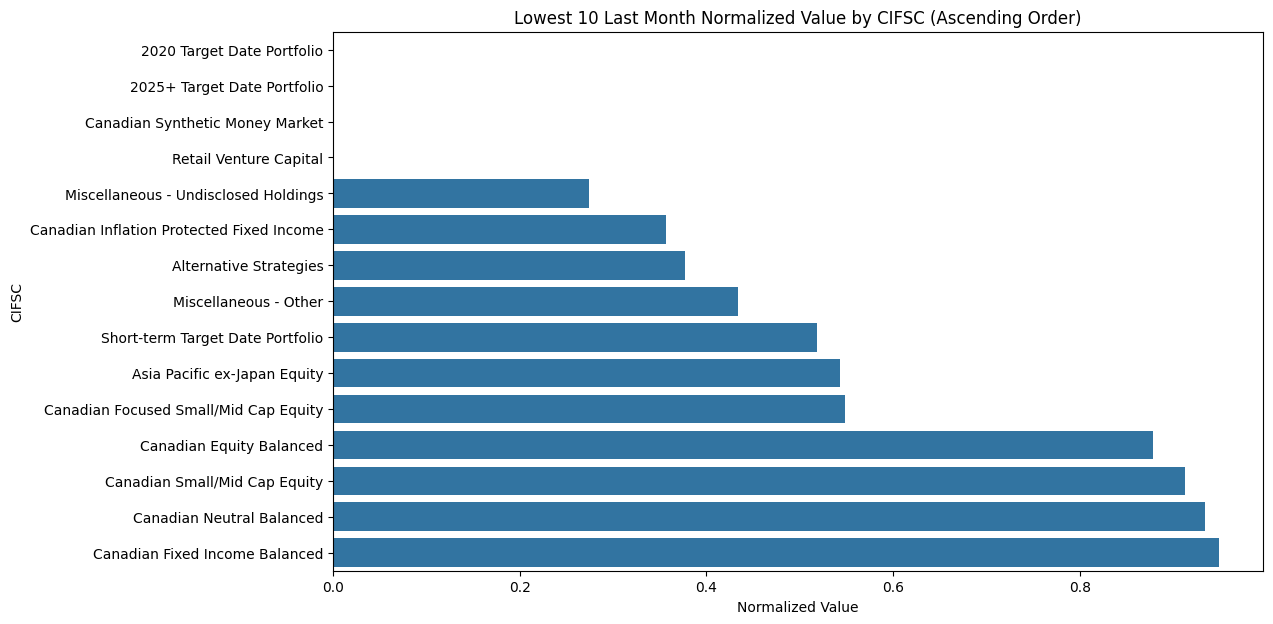

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is already loaded as df

# Step 1: Sort the DataFrame by 'Month Number' to ensure the latest month is last for each CIFSC
df_sorted = Normalizedtable.sort_values("Month Number")

# Step 2: Extract the last month's data for each CIFSC
last_month = df_sorted.groupby("CIFSC").tail(1)

# Step 3: Sort the extracted data by normalized_value in ascending order
last_month_sorted = last_month.sort_values("normalized_value")

# Step 4: Select the lowest 10 values
lowest_15 = last_month_sorted.head(15)

# Step 5: Create a horizontal bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=lowest_15, x="normalized_value", y="CIFSC", order=lowest_15["CIFSC"])
plt.title("Lowest 10 Last Month Normalized Value by CIFSC (Ascending Order)")
plt.xlabel("Normalized Value")
plt.ylabel("CIFSC")
plt.show()


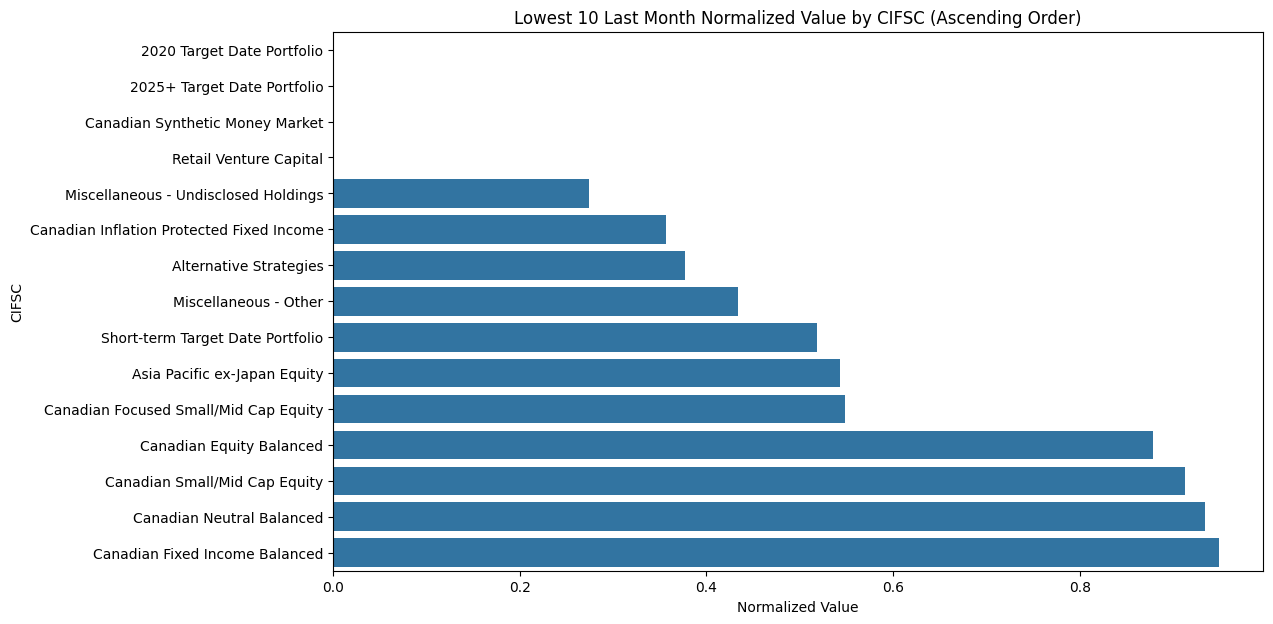

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is already loaded as df

# Step 1: Sort the DataFrame by 'Month Number' to ensure the latest month is last for each CIFSC
df_sorted = Normalizedtable.sort_values("Month Number")

# Step 2: Extract the last month's data for each CIFSC
last_month = df_sorted.groupby("CIFSC").tail(1)

# Step 3: Sort the extracted data by normalized_value in ascending order
last_month_sorted = last_month.sort_values("normalized_value")

# Step 4: Select the lowest 10 values
lowest_15 = last_month_sorted.head(15)

# Step 5: Create a horizontal bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=lowest_15, x="normalized_value", y="CIFSC", order=lowest_15["CIFSC"])
plt.title("Lowest 10 Last Month Normalized Value by CIFSC (Ascending Order)")
plt.xlabel("Normalized Value")
plt.ylabel("CIFSC")
plt.show()

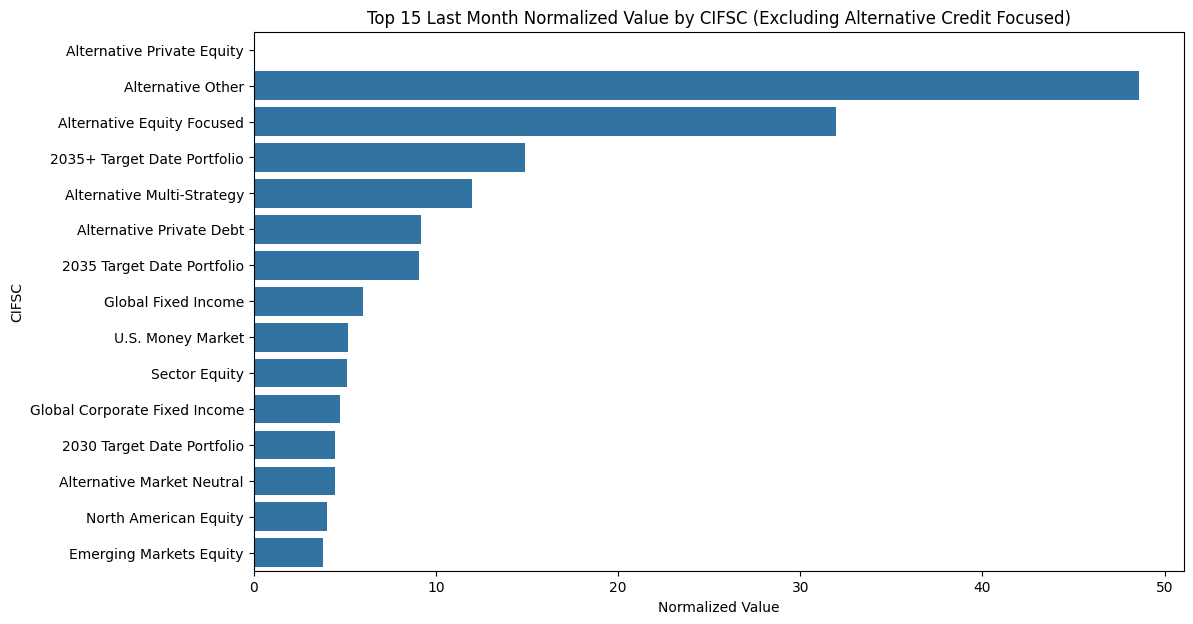

In [100]:
# Assuming your DataFrame is already loaded as df

# Step 1: Sort by 'Month Number' to ensure the latest month is last for each CIFSC
df_sorted = Normalizedtable.sort_values("Month Number")

# Step 2: Extract the last month's data for each CIFSC
last_month = df_sorted.groupby("CIFSC").tail(1)

# Step 3: Exclude the specified CIFSC (wrap the value in quotes)
excluded_cifsc = 'Alternative Credit Focused'
last_month_filtered = last_month[last_month["CIFSC"] != excluded_cifsc]

# Step 4: Sort by normalized_value in descending order and select the top 15
last_month_sorted = last_month_filtered.sort_values("normalized_value", ascending=False)
top_15 = last_month_sorted.head(15)

# Step 5: Create a horizontal bar plot for the top 15 values
plt.figure(figsize=(12, 7))
sns.barplot(data=top_15, x="normalized_value", y="CIFSC", order=top_15["CIFSC"])
plt.title(f"Top 15 Last Month Normalized Value by CIFSC (Excluding {excluded_cifsc})")
plt.xlabel("Normalized Value")
plt.ylabel("CIFSC")
plt.show()


In [101]:
Normalizedtable.head()

,Month Number,CIFSC,total_net_assets,total_gross_sales,total_redemptions,normalized_value
0,1,Energy Equity,2.869556e+09,165349430.0,91221320.0,1.000000
1,2,Energy Equity,2.892809e+09,307619650.0,226196750.0,1.008103
2,3,Energy Equity,3.153176e+09,125836980.0,131798630.0,1.098838
3,4,Energy Equity,3.244401e+09,115502910.0,171237840.0,1.130628
4,5,Energy Equity,3.231803e+09,281287140.0,367508630.0,1.126238


## ⬜⬜ Large CIFSC Categories

In [102]:
# Assuming your original dataframe is called df
duckdb.register("ConsolidatedGroupedCIFSCandMonth", mergedDF)

query = """
SELECT 
  "Month Number", 
  ConsolidatedCIFSC,
  SUM("Net Assets") AS total_net_assets,
  SUM("Gross Sales") AS total_gross_sales,
  SUM("Redemptions") AS total_redemptions,
FROM ConsolidatedGroupedCIFSCandMonth
GROUP BY "Month Number", ConsolidatedCIFSC;
"""

ConsolidatedGroupedCIFSCandMonth = duckdb.query(query).to_df()
#print(ConsolidatedGroupedCIFSCandMonth)
#ConsolidatedGroupedCIFSCandMonth.head()

duckdb.register("my_CompleteConsolidatedOrdered_table", ConsolidatedGroupedCIFSCandMonth)

query = """
SELECT *
FROM my_CompleteConsolidatedOrdered_table
ORDER BY ConsolidatedCIFSC, "Month Number";
"""
ConsoResultOrdered_df = duckdb.query(query).to_df()
# print(ConsoResultOrdered_df)
ConsoResultOrdered_df.head()

,Month Number,ConsolidatedCIFSC,total_net_assets,total_gross_sales,total_redemptions
0,1,Alternative,3.957954e+09,3.482742e+08,319979330.0
1,2,Alternative,3.986334e+09,4.598503e+08,371412160.0
2,3,Alternative,4.027764e+09,4.444093e+08,424108940.0
3,4,Alternative,4.083393e+09,4.106078e+08,377811230.0
4,5,Alternative,4.093671e+09,4.023552e+08,373773920.0


In [103]:
# Register your Pandas DataFrame as a DuckDB table
duckdb.register("my_CosoNormalizedtable", ConsoResultOrdered_df)

query = """
SELECT 
  "Month Number", 
  ConsolidatedCIFSC, 
  total_net_assets,
  total_gross_sales,
  total_redemptions,
  total_net_assets / FIRST_VALUE(total_net_assets) OVER (PARTITION BY ConsolidatedCIFSC ORDER BY "Month Number") AS normalized_value
FROM my_CosoNormalizedtable;
"""

# Execute the query and convert the result to a Pandas DataFrame.
CosoNormalizedtable = duckdb.query(query).to_df()
CosoNormalizedtable.head()

,Month Number,ConsolidatedCIFSC,total_net_assets,total_gross_sales,total_redemptions,normalized_value
0,1,Canadian Equity,1.849257e+11,2.098807e+09,4.297135e+09,1.000000
1,2,Canadian Equity,1.834101e+11,2.652806e+09,2.609612e+09,0.991804
2,3,Canadian Equity,1.943519e+11,5.083842e+09,4.273486e+09,1.050973
3,4,Canadian Equity,1.989717e+11,2.523802e+09,2.977450e+09,1.075955
4,5,Canadian Equity,2.031228e+11,2.324924e+09,1.993885e+09,1.098403


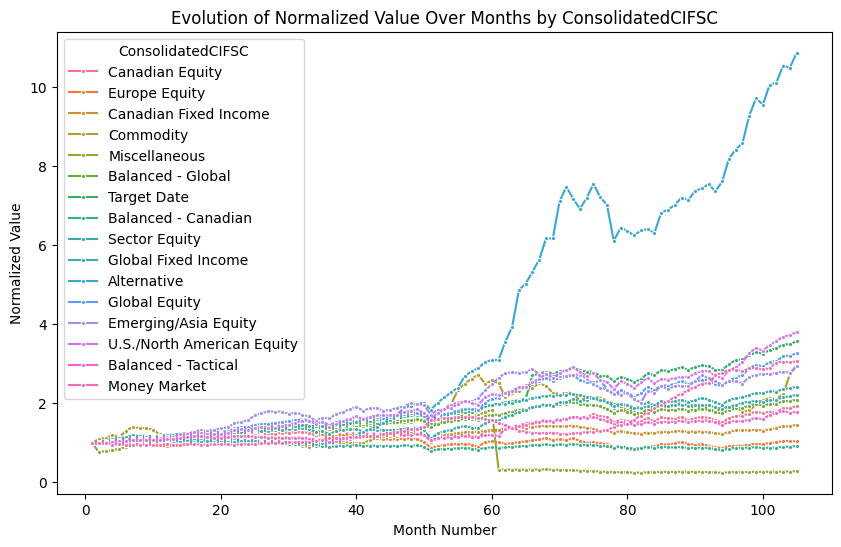

In [104]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=CosoNormalizedtable, x='Month Number', y='normalized_value', hue='ConsolidatedCIFSC', marker='.')
plt.title('Evolution of Normalized Value Over Months by ConsolidatedCIFSC')
plt.xlabel('Month Number')
plt.ylabel('Normalized Value')
plt.legend(title='ConsolidatedCIFSC')
plt.show()

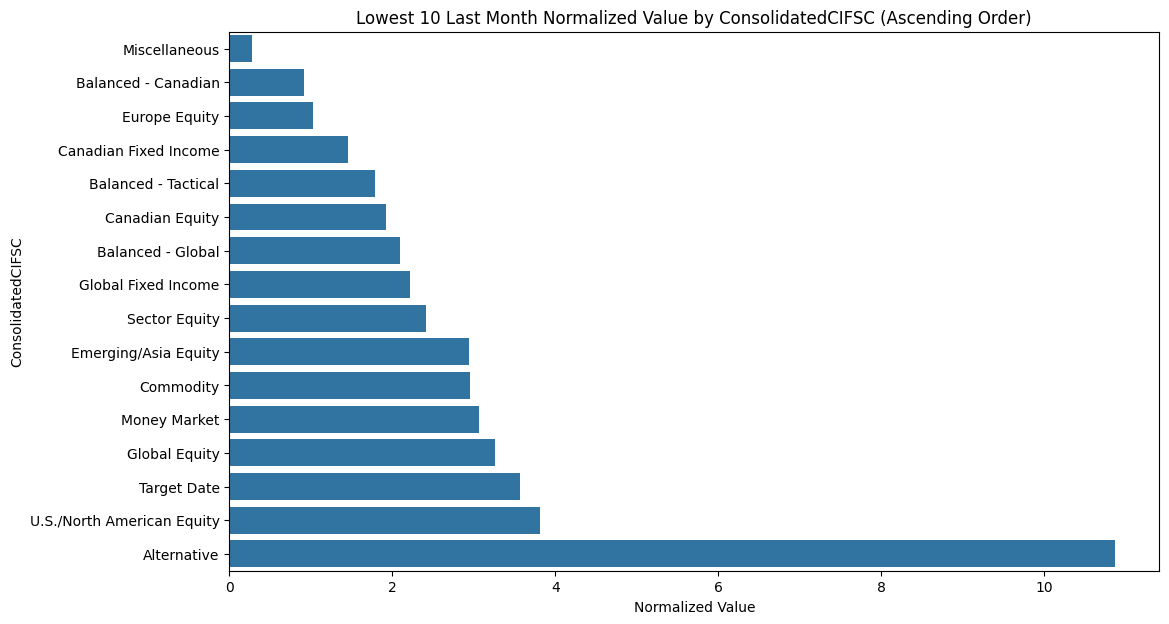

In [105]:
# Assuming your DataFrame is already loaded as df

# Step 1: Sort the DataFrame by 'Month Number' to ensure the latest month is last for each CIFSC
df_sorted = CosoNormalizedtable.sort_values("Month Number")

# Step 2: Extract the last month's data for each CIFSC
last_month = df_sorted.groupby("ConsolidatedCIFSC").tail(1)

# Step 3: Sort the extracted data by normalized_value in ascending order
last_month_sorted = last_month.sort_values("normalized_value")

# Step 4: Select the lowest 10 values
lowest_15 = last_month_sorted.head(20)

# Step 5: Create a horizontal bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=lowest_15, x="normalized_value", y="ConsolidatedCIFSC", order=lowest_15["ConsolidatedCIFSC"])
plt.title("Lowest 10 Last Month Normalized Value by ConsolidatedCIFSC (Ascending Order)")
plt.xlabel("Normalized Value")
plt.ylabel("ConsolidatedCIFSC")
plt.show()

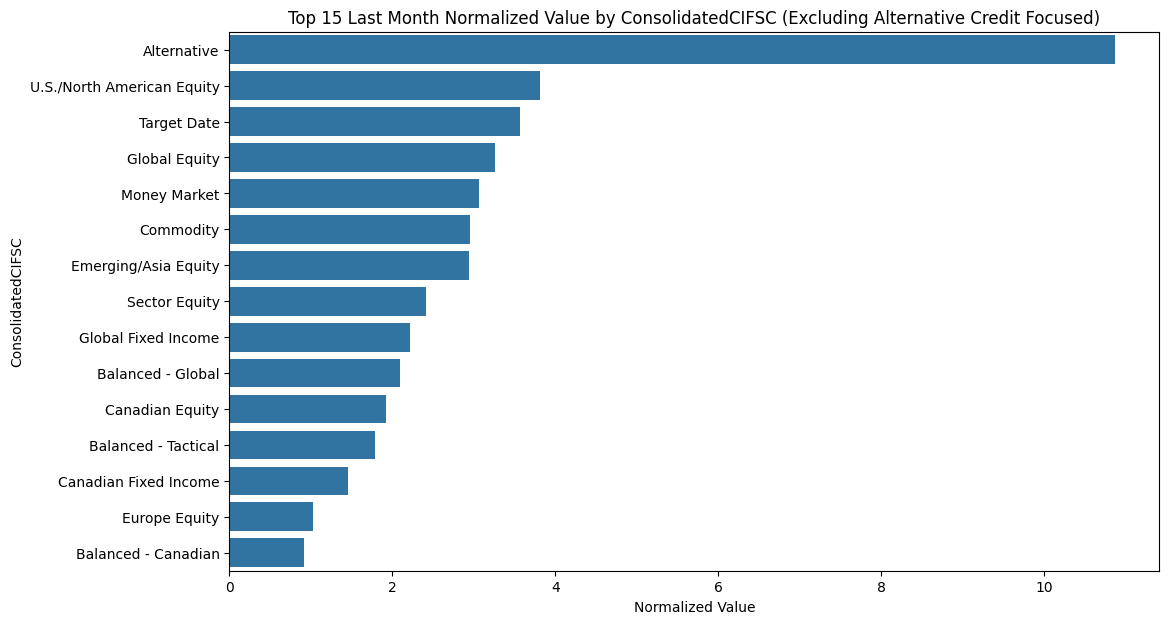

In [106]:
# Step 1: Sort by 'Month Number' to ensure the latest month is last for each CIFSC
df_sorted = df_sorted = CosoNormalizedtable.sort_values("Month Number").sort_values("Month Number")

# Step 2: Extract the last month's data for each CIFSC
last_month = df_sorted.groupby("ConsolidatedCIFSC").tail(1)


# Step 3: Sort by normalized_value in descending order and select the top 15
last_month_sorted = last_month.sort_values("normalized_value", ascending=False)
top_15 = last_month_sorted.head(15)

# Step 5: Create a horizontal bar plot for the top 15 values
plt.figure(figsize=(12, 7))
sns.barplot(data=top_15, x="normalized_value", y="ConsolidatedCIFSC", order=top_15["ConsolidatedCIFSC"])
plt.title(f"Top 15 Last Month Normalized Value by ConsolidatedCIFSC (Excluding {excluded_cifsc})")
plt.xlabel("Normalized Value")
plt.ylabel("ConsolidatedCIFSC")
plt.show()

## 💱💱 VIX

In [107]:
myVIXfile = ("VIX.xlsx")
VIXDF = pd.read_excel(myVIXfile)
VIXDF.head()

,Month Number,VIX
0,1,23.717895
1,2,22.517000
2,3,15.849091
3,4,14.300476
4,5,14.852857


In [108]:
# Register both dataframes
duckdb.register("CosoNormalizedtable", CosoNormalizedtable)
duckdb.register("VIXDF", VIXDF)

# Perform a LEFT JOIN to add the ConsolidatedCIFSC column
query = """
SELECT 
    m.*,
    c.VIX
FROM CosoNormalizedtable m
LEFT JOIN VIXDF c
    ON m."Month Number" = c."Month Number"
"""

# Run the query and assign the result back to mergedDF
CosoNormalizedtable = duckdb.query(query).to_df()
CosoNormalizedtable.head()

,Month Number,ConsolidatedCIFSC,total_net_assets,total_gross_sales,total_redemptions,normalized_value,VIX
0,1,Canadian Equity,1.849257e+11,2.098807e+09,4.297135e+09,1.000000,23.717895
1,2,Canadian Equity,1.834101e+11,2.652806e+09,2.609612e+09,0.991804,22.517000
2,3,Canadian Equity,1.943519e+11,5.083842e+09,4.273486e+09,1.050973,15.849091
3,4,Canadian Equity,1.989717e+11,2.523802e+09,2.977450e+09,1.075955,14.300476
4,5,Canadian Equity,2.031228e+11,2.324924e+09,1.993885e+09,1.098403,14.852857


In [109]:
import statsmodels.api as sm

# Assume your dataset is in a DataFrame called df

def run_regression(group):

    # Define the independent variable (VIX) and dependent variable (total_gross_sales)
    X = group["VIX"]
    y = group["total_gross_sales"]
    
    # Add a constant term (intercept)
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    # Return desired regression metrics as a Series
    return pd.Series({
        "intercept": model.params["const"],
        "slope": model.params["VIX"],
        "R2": model.rsquared,
        "p_value_slope": model.pvalues["VIX"]
    })

# Group the DataFrame by ConsolidatedCIFSC and apply the regression function to each group
results_table = CosoNormalizedtable.groupby("ConsolidatedCIFSC").apply(run_regression).reset_index()

results_table.head(17)


C:\Users\Bernier\AppData\Local\Temp\ipykernel_12736\2062294099.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_table = CosoNormalizedtable.groupby("ConsolidatedCIFSC").apply(run_regression).reset_index()


,ConsolidatedCIFSC,intercept,slope,R2,p_value_slope
0,Alternative,5.095383e+08,2.445423e+07,0.075140,0.004660
1,Balanced - Canadian,1.136717e+09,-1.069584e+07,0.058288,0.013097
2,Balanced - Global,5.153551e+09,-5.196380e+06,0.000578,0.807639
3,Balanced - Tactical,4.580033e+08,1.226073e+05,0.000021,0.962662
4,Canadian Equity,2.944750e+09,8.422585e+07,0.151764,0.000040
5,Canadian Fixed Income,4.679444e+09,2.428300e+07,0.015409,0.207070
6,Commodity,-1.495974e+07,3.492579e+06,0.102046,0.000895
7,Emerging/Asia Equity,3.341999e+08,6.854242e+06,0.031813,0.068694
8,Europe Equity,9.319414e+07,1.974893e+04,0.000001,0.990536
9,Global Equity,2.726328e+09,5.289385e+07,0.059429,0.012210


In [110]:
CosoNormalizedtable["PerInflow"] = CosoNormalizedtable["total_gross_sales"] / CosoNormalizedtable["total_net_assets"]
CosoNormalizedtable.head()

,Month Number,ConsolidatedCIFSC,total_net_assets,total_gross_sales,total_redemptions,normalized_value,VIX,PerInflow
0,1,Canadian Equity,1.849257e+11,2.098807e+09,4.297135e+09,1.000000,23.717895,0.011349
1,2,Canadian Equity,1.834101e+11,2.652806e+09,2.609612e+09,0.991804,22.517000,0.014464
2,3,Canadian Equity,1.943519e+11,5.083842e+09,4.273486e+09,1.050973,15.849091,0.026158
3,4,Canadian Equity,1.989717e+11,2.523802e+09,2.977450e+09,1.075955,14.300476,0.012684
4,5,Canadian Equity,2.031228e+11,2.324924e+09,1.993885e+09,1.098403,14.852857,0.011446


In [111]:
CosoNormalizedtable["PerSales"] = (
    CosoNormalizedtable["total_gross_sales"] /
    CosoNormalizedtable.groupby("Month Number")["total_gross_sales"].transform("sum")
)
CosoNormalizedtable.head()

,Month Number,ConsolidatedCIFSC,total_net_assets,total_gross_sales,total_redemptions,normalized_value,VIX,PerInflow,PerSales
0,1,Canadian Equity,1.849257e+11,2.098807e+09,4.297135e+09,1.000000,23.717895,0.011349,0.089037
1,2,Canadian Equity,1.834101e+11,2.652806e+09,2.609612e+09,0.991804,22.517000,0.014464,0.096750
2,3,Canadian Equity,1.943519e+11,5.083842e+09,4.273486e+09,1.050973,15.849091,0.026158,0.176185
3,4,Canadian Equity,1.989717e+11,2.523802e+09,2.977450e+09,1.075955,14.300476,0.012684,0.113958
4,5,Canadian Equity,2.031228e+11,2.324924e+09,1.993885e+09,1.098403,14.852857,0.011446,0.099646


In [112]:
def run_regression(group):

    # Define the independent variable (VIX) and dependent variable (total_gross_sales)
    X = group["VIX"]
    y = group["PerInflow"]
    
    # Add a constant term (intercept)
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    # Return desired regression metrics as a Series
    return pd.Series({
        "intercept": model.params["const"],
        "slope": model.params["VIX"],
        "R2": model.rsquared,
        "p_value_slope": model.pvalues["VIX"]
    })

# Group the DataFrame by ConsolidatedCIFSC and apply the regression function to each group
results_table = CosoNormalizedtable.groupby("ConsolidatedCIFSC").apply(run_regression).reset_index()

results_table.head(17)

C:\Users\Bernier\AppData\Local\Temp\ipykernel_12736\1589253944.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_table = CosoNormalizedtable.groupby("ConsolidatedCIFSC").apply(run_regression).reset_index()


,ConsolidatedCIFSC,intercept,slope,R2,p_value_slope
0,Alternative,0.072106,5.072858e-04,1.165435e-02,2.730009e-01
1,Balanced - Canadian,0.007073,-3.180704e-05,1.413040e-02,2.271336e-01
2,Balanced - Global,0.013069,-8.911450e-05,2.855159e-02,8.486381e-02
3,Balanced - Tactical,0.013452,-9.848038e-06,3.100247e-04,8.585051e-01
4,Canadian Equity,0.010506,3.926973e-04,2.316583e-01,2.019776e-07
5,Canadian Fixed Income,0.019566,5.279016e-05,5.889456e-03,4.365014e-01
6,Commodity,-0.001805,1.301314e-03,1.260588e-01,2.020424e-04
7,Emerging/Asia Equity,0.019893,1.465510e-04,1.048571e-02,2.985909e-01
8,Europe Equity,0.012724,1.122381e-04,2.490084e-03,6.131904e-01
9,Global Equity,0.013733,1.490308e-04,5.144410e-02,1.997964e-02


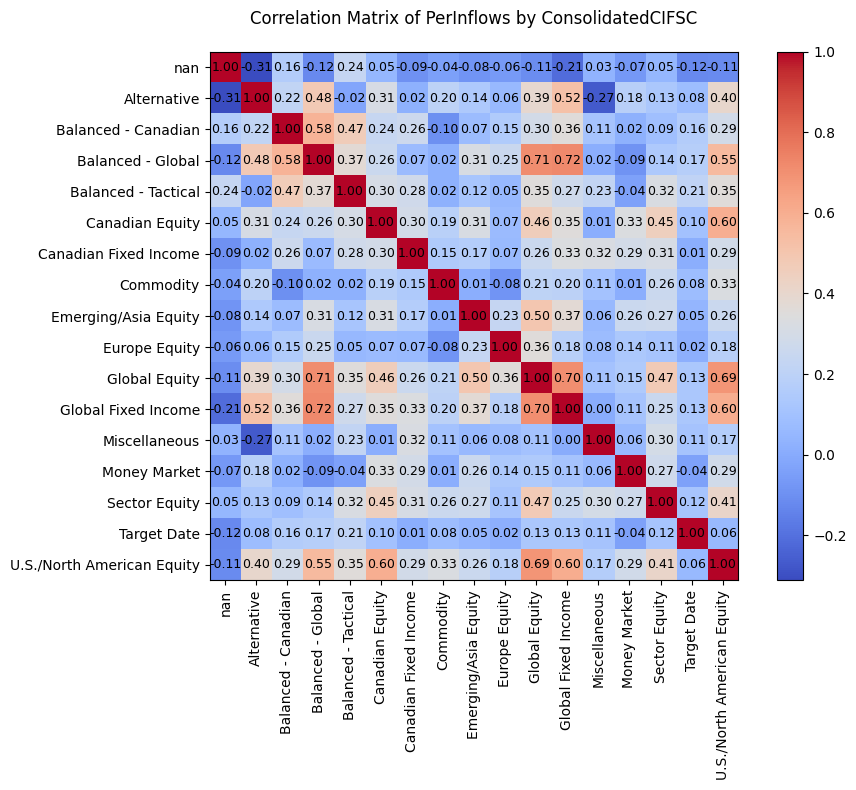

In [113]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your original DataFrame is named df
# Pivot the DataFrame so that rows are Month Numbers and columns are ConsolidatedCIFSC, with PerInflow as the values
pivot_df = CosoNormalizedtable.pivot(index='Month Number', columns='ConsolidatedCIFSC', values='PerInflow')

# Compute the correlation matrix among the different ConsolidatedCIFSC's PerInflow
corr_table = pivot_df.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap with a nice color palette (coolwarm)
cax = ax.imshow(corr_table, interpolation='nearest', cmap='coolwarm')

# Add a colorbar to the side
fig.colorbar(cax)

# Set ticks and labels for x and y axes
ax.set_xticks(np.arange(len(corr_table.columns)))
ax.set_xticklabels(corr_table.columns, rotation=90, fontsize=10)
ax.set_yticks(np.arange(len(corr_table.index)))
ax.set_yticklabels(corr_table.index, fontsize=10)

# Annotate each cell with the correlation coefficient
for i in range(len(corr_table.index)):
    for j in range(len(corr_table.columns)):
        text = ax.text(j, i, f"{corr_table.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black", fontsize=9)

# Add a title and adjust layout
ax.set_title("Correlation Matrix of PerInflows by ConsolidatedCIFSC", pad=20)
plt.tight_layout()
plt.show()



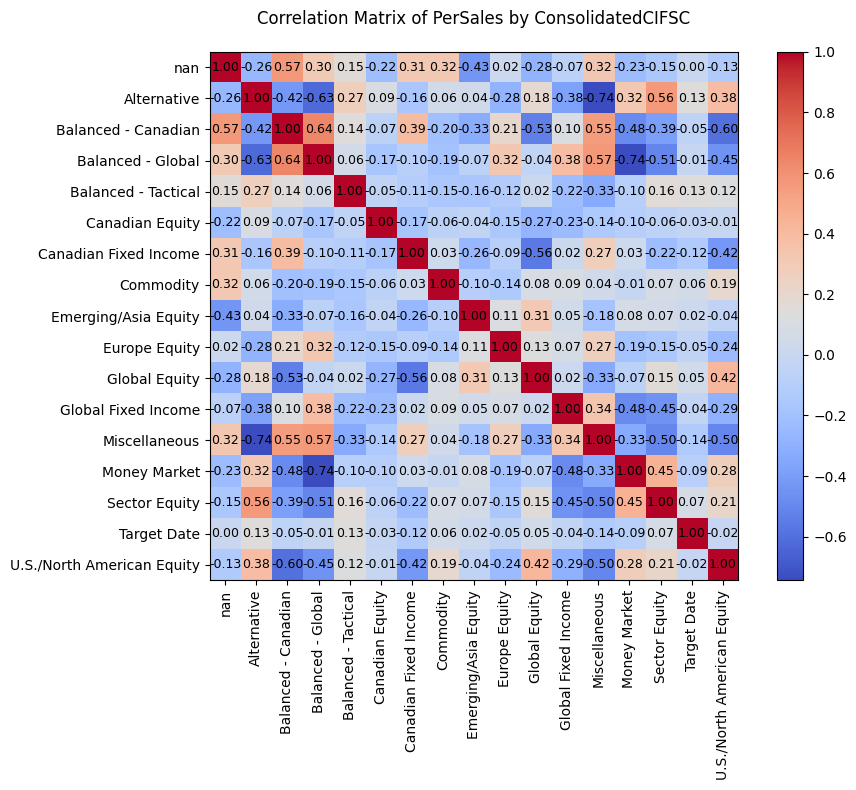

In [114]:
# Assuming your original DataFrame is named df
# Pivot the DataFrame so that rows are Month Numbers and columns are ConsolidatedCIFSC, with PerInflow as the values
pivot_df = CosoNormalizedtable.pivot(index='Month Number', columns='ConsolidatedCIFSC', values='PerSales')

# Compute the correlation matrix among the different ConsolidatedCIFSC's PerSales
corr_table = pivot_df.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap with a nice color palette (coolwarm)
cax = ax.imshow(corr_table, interpolation='nearest', cmap='coolwarm')

# Add a colorbar to the side
fig.colorbar(cax)

# Set ticks and labels for x and y axes
ax.set_xticks(np.arange(len(corr_table.columns)))
ax.set_xticklabels(corr_table.columns, rotation=90, fontsize=10)
ax.set_yticks(np.arange(len(corr_table.index)))
ax.set_yticklabels(corr_table.index, fontsize=10)

# Annotate each cell with the correlation coefficient
for i in range(len(corr_table.index)):
    for j in range(len(corr_table.columns)):
        text = ax.text(j, i, f"{corr_table.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black", fontsize=9)

# Add a title and adjust layout
ax.set_title("Correlation Matrix of PerSales by ConsolidatedCIFSC", pad=20)
plt.tight_layout()
plt.show()


In [115]:
CosoNormalizedtable.info()
CosoNormalizedtable.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month Number       1780 non-null   int64  
 1   ConsolidatedCIFSC  1680 non-null   object 
 2   total_net_assets   1780 non-null   float64
 3   total_gross_sales  1780 non-null   float64
 4   total_redemptions  1780 non-null   float64
 5   normalized_value   1780 non-null   float64
 6   VIX                1780 non-null   float64
 7   PerInflow          1779 non-null   float64
 8   PerSales           1780 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 125.3+ KB


,Month Number,total_net_assets,total_gross_sales,total_redemptions,normalized_value,VIX,PerInflow,PerSales
count,1780.000000,1.780000e+03,1.780000e+03,1.780000e+03,1780.000000,1780.000000,1779.000000,1780.000000
mean,52.966292,1.134627e+11,2.049049e+09,1.790031e+09,1.588461,18.465820,0.028031,0.058989
std,30.353806,1.327339e+11,2.146973e+09,1.861657e+09,1.148875,7.008290,0.037714,0.058326
min,1.000000,0.000000e+00,0.000000e+00,-3.500000e+02,0.000000,10.125455,0.000000,0.000000
25%,27.000000,9.066299e+09,2.059445e+08,1.821376e+08,1.056288,13.678095,0.011198,0.005812
50%,53.000000,3.978068e+10,1.079904e+09,1.214126e+09,1.319689,17.416190,0.017712,0.033150
75%,79.000000,2.125279e+11,3.554759e+09,3.072678e+09,1.857332,22.169565,0.029300,0.107890
max,105.000000,6.052383e+11,1.046756e+10,1.123915e+10,10.866547,57.736818,1.000000,0.246338


In [116]:

import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm  # For regression analysis


In [117]:
import yfinance as yf
import pandas as pd

# Download daily VIX data from Yahoo Finance (ticker may be '^VIX' if needed)
vix_df = yf.download("aapl", start="2016-01-01", end="2023-12-31", interval="1d", progress=False)
vix_df.reset_index(inplace=True)

# Keep only the columns we need: Date and Close (renamed to VIX)
vix_df = vix_df[['Date', 'Close']]
vix_df.rename(columns={'Close': 'aapl'}, inplace=True)

print(vix_df.head())




1 Failed download:
['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Empty DataFrame
Columns: [Date, aapl]
Index: []


C:\Users\Bernier\AppData\Local\Temp\ipykernel_12736\2644351328.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_df.rename(columns={'Close': 'aapl'}, inplace=True)


In [118]:
# Merge the VIX data with your existing table on "Month Number"
merged_df = pd.merge(df, vix_df, on="Month Number", how="left")

print(merged_df.head())


NameError: name 'df' is not defined

In [101]:
# Prepare the independent variable (VIX) and dependent variable (total_gross_sales_by_month)
X = merged_df['VIX']
Y = merged_df['total_gross_sales_by_month']

# Add a constant term for the intercept in the regression model
X = sm.add_constant(X)

# Fit an OLS regression model
model = sm.OLS(Y, X).fit()

print(model.summary())


NameError: name 'merged_df' is not defined

In [102]:
# Compute correlation matrix for VIX and your three columns
cols = ['VIX', 'total_gross_sales_by_month', 'total_redemption_by_month', 'total_net_flows_by_month']
correlation_matrix = merged_df[cols].corr()
print(correlation_matrix)


NameError: name 'merged_df' is not defined